# **Previsão de Vendas Mensais em Rede de Varejo**

In [3]:
# Para manipulação de dados
import pandas as pd
import numpy as np

# Para visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Para pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modelos de Regressão
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Métricas de Avaliação
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
# Carregar os datasets
df_train = pd.read_csv('datasets/train.csv', low_memory=False)
df_store = pd.read_csv('datasets/store.csv')

# Juntar os dois dataframes
df_completo = pd.merge(df_train, df_store, on='Store')

# --- Reduzir o dataset para um treinamento mais rápido ---
print(f"Tamanho original do dataset: {len(df_completo)} linhas")

# Vamos pegar uma amostra aleatória de 100.000 linhas
df = df_completo.sample(n=100000, random_state=42).copy()
print(f"Tamanho do novo dataset (amostra): {len(df)} linhas")

Tamanho original do dataset: 1017209 linhas
Tamanho do novo dataset (amostra): 100000 linhas


In [5]:
# Filtrar apenas por lojas abertas (Open == 1) e com vendas (Sales > 0)
df = df[(df['Open'] == 1) & (df['Sales'] > 0)].copy()

# Remover colunas que não usaremos ou que causam vazamento de dados (Customers)
df = df.drop(columns=['Customers', 'Open']) # 'Open' é sempre 1 agora

print("Dados após limpeza inicial:")
print(df.head())

Dados após limpeza inicial:
        Store  DayOfWeek        Date  Sales  Promo StateHoliday  \
923026    592          2  2013-03-26   5548      1            0   
731180    526          6  2013-09-14   7467      0            0   
790350    601          2  2013-07-23   3360      0            0   
252134    953          1  2014-12-15  11414      1            0   
666826    842          1  2013-11-11  14126      0            0   

        SchoolHoliday StoreType Assortment  CompetitionDistance  \
923026              1         a          a               2540.0   
731180              0         a          a                120.0   
790350              1         d          a               8220.0   
252134              0         a          a              19830.0   
666826              0         d          c               1200.0   

        CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
923026                        6.0                    2005.0       0   
731180                  

In [6]:
# Extrair features de data
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter

# Simplificar feriados: 0 = Sem feriado, 1 = Feriado (qualquer tipo)
df['StateHoliday'] = df['StateHoliday'].map({'0': 0, 0: 0, 'a': 1, 'b': 1, 'c': 1})
df['StateHoliday'] = df['StateHoliday'].astype(int)

# Tratar valores nulos em 'CompetitionDistance' com a mediana
median_distance = df['CompetitionDistance'].median()
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(median_distance)

print("Dados após engenharia de features:")
print(df.head())

Dados após engenharia de features:
        Store  DayOfWeek       Date  Sales  Promo  StateHoliday  \
923026    592          2 2013-03-26   5548      1             0   
731180    526          6 2013-09-14   7467      0             0   
790350    601          2 2013-07-23   3360      0             0   
252134    953          1 2014-12-15  11414      1             0   
666826    842          1 2013-11-11  14126      0             0   

        SchoolHoliday StoreType Assortment  CompetitionDistance  ...  \
923026              1         a          a               2540.0  ...   
731180              0         a          a                120.0  ...   
790350              1         d          a               8220.0  ...   
252134              0         a          a              19830.0  ...   
666826              0         d          c               1200.0  ...   

        CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
923026                    2005.0       0           

In [7]:
# Lista de colunas que usaremos como features (preditoras)
colunas_features = [
    'Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
    'StoreType', 'Assortment', 'CompetitionDistance', 'Year', 'Month',
    'WeekOfYear', 'Quarter'
]

# Separar as colunas por tipo
features_categoricas = ['StoreType', 'Assortment', 'DayOfWeek', 'Store']
features_numericas = [coluna for coluna in colunas_features if coluna not in features_categoricas]

# Definir X (features) e y (alvo)
X = df[colunas_features]
y = df['Sales'] # Nosso alvo

print(f"Total de features: {len(colunas_features)}")
print(f"Features Numéricas: {features_numericas}")
print(f"Features Categóricas: {features_categoricas}")

Total de features: 12
Features Numéricas: ['Promo', 'StateHoliday', 'SchoolHoliday', 'CompetitionDistance', 'Year', 'Month', 'WeekOfYear', 'Quarter']
Features Categóricas: ['StoreType', 'Assortment', 'DayOfWeek', 'Store']


In [8]:
# Dividir em dados de treino e teste (80% treino, 20% teste)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamanho do conjunto de treino: {len(X_treino)} amostras")
print(f"Tamanho do conjunto de teste: {len(X_teste)} amostras")

Tamanho do conjunto de treino: 66371 amostras
Tamanho do conjunto de teste: 16593 amostras


In [9]:
# Pipeline para features numéricas:
# Preenche valores nulos (NaN) com a mediana
# Padroniza a escala das features (StandardScaler)
transformador_numerico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para features categóricas:
# Preenche valores nulos (NaN) com a string 'missing'
# Aplica o OneHotEncoder (cria colunas dummy)
transformador_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar os dois transformadores em um único pré-processador
pre_processador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, features_numericas),
        ('cat', transformador_categorico, features_categoricas)
    ])

In [10]:
# Pipeline da Regressão Linear
pipeline_regressao_linear = Pipeline(steps=[('preprocessor', pre_processador),
                                            ('model', LinearRegression())])
print("Treinando a Regressão Linear...")
pipeline_regressao_linear.fit(X_treino, y_treino)


# Pipeline da Árvore de Decisão
pipeline_arvore_decisao = Pipeline(steps=[('preprocessor', pre_processador),
                                          ('model', DecisionTreeRegressor(random_state=42, max_depth=100))])
print("Treinando a Árvore de Decisão...")
pipeline_arvore_decisao.fit(X_treino, y_treino)


# Pipeline do XGBoost
pipeline_xgboost = Pipeline(steps=[('preprocessor', pre_processador),
                                   ('model', XGBRegressor(
                                       random_state=42,
                                       n_estimators=500,
                                       learning_rate=0.05,
                                       max_depth=8,
                                       objective='reg:squarederror'
                                   ))])
print("Treinando o XGBoost...")
pipeline_xgboost.fit(X_treino, y_treino)

print("Treinamento concluído!")

Treinando a Regressão Linear...
Treinando a Árvore de Decisão...
Treinando o XGBoost...
Treinamento concluído!


In [11]:
# Criar um dicionário para armazenar os pipelines treinados
modelos = {
    "Regressão Linear": pipeline_regressao_linear,
    "Árvore de Decisão": pipeline_arvore_decisao,
    "XGBoost": pipeline_xgboost
}

# Lista para guardar os resultados
resultados = []

print("Avaliando modelos nos dados de teste:")
for nome, modelo in modelos.items():
    # Fazer previsões com os dados de teste
    y_previsao = modelo.predict(X_teste)
    
    # Calcular métricas
    rmse = np.sqrt(mean_squared_error(y_teste, y_previsao))
    mae = mean_absolute_error(y_teste, y_previsao)
    r2 = r2_score(y_teste, y_previsao)
    
    resultados.append([nome, rmse, mae, r2])
    
# Criar um DataFrame para facilitar a visualização
df_resultados = pd.DataFrame(resultados, columns=["Modelo", "RMSE", "MAE", "R²"])

print(df_resultados)

Avaliando modelos nos dados de teste:
              Modelo         RMSE          MAE        R²
0   Regressão Linear  1509.092142  1073.501134  0.754875
1  Árvore de Decisão  1719.101763  1143.986727  0.681903
2            XGBoost  1779.837212  1379.671387  0.659030



--- Coeficientes do Modelo Linear (Maior Impacto) ---
         Feature   Coeficiente       Impacto
838    Store_817  15717.149946  15717.149946
1135  Store_1114  13359.413852  13359.413852
534    Store_513  11933.590150  11933.590150
272    Store_251  11708.385813  11708.385813
863    Store_842  11286.566759  11286.566759
283    Store_262  10524.167099  10524.167099
809    Store_788  10081.388195  10081.388195
404    Store_383   9291.831163   9291.831163
719    Store_698   8958.045242   8958.045242
544    Store_523   8312.346741   8312.346741
777    Store_756   8022.395452   8022.395452
607    Store_586   7847.516960   7847.516960
401    Store_380   7748.011926   7748.011926
565    Store_544   7544.675956   7544.675956
616    Store_595   7541.446480   7541.446480
1054  Store_1033   7360.002636   7360.002636
357    Store_336   7266.605284   7266.605284
567    Store_546   7052.985020   7052.985020
341    Store_320   6931.965664   6931.965664
754    Store_733   6371.217437   6371.217437


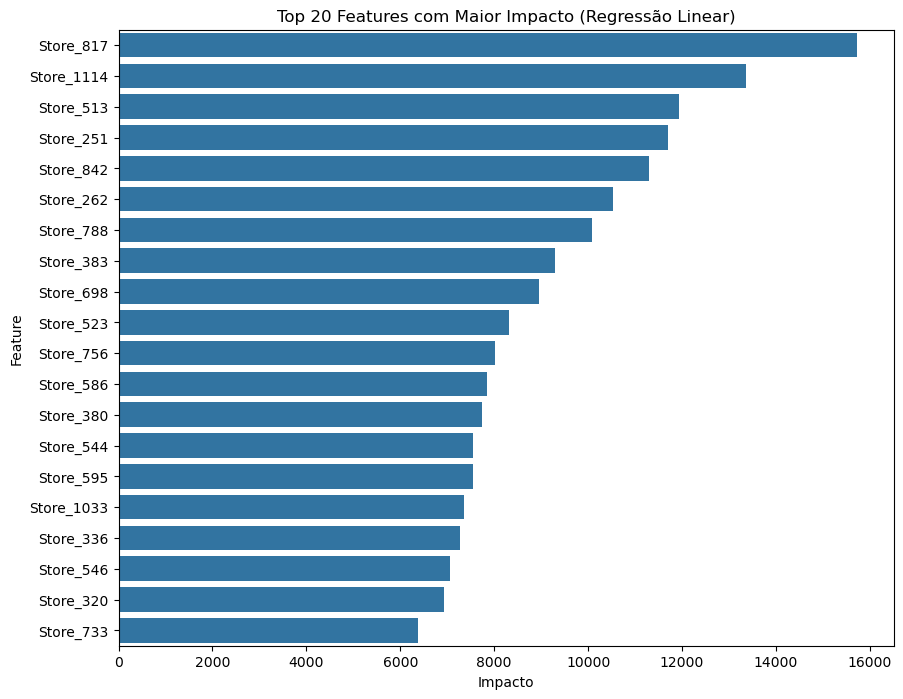

In [12]:
# --- Análise de Impacto do *melhor modelo* (Regressão Linear) ---

# Obter o modelo linear de dentro do pipeline
modelo_linear = pipeline_regressao_linear.named_steps['model']

# Obter os nomes das features categóricas DEPOIS do OneHotEncoding
nomes_features_categoricas = pipeline_regressao_linear.named_steps['preprocessor'] \
                                .named_transformers_['cat'] \
                                .named_steps['onehot'] \
                                .get_feature_names_out(features_categoricas)

# Juntar os nomes das features numéricas e categóricas
todos_nomes_features = np.concatenate([features_numericas, nomes_features_categoricas])

# Criar um DataFrame com os coeficientes
# Usamos o valor absoluto (np.abs) para medir o 'tamanho' do impacto
df_coeficientes = pd.DataFrame({
    'Feature': todos_nomes_features,
    'Coeficiente': modelo_linear.coef_,
    'Impacto': np.abs(modelo_linear.coef_)
}).sort_values(by='Impacto', ascending=False)

print("\n--- Coeficientes do Modelo Linear (Maior Impacto) ---")
print(df_coeficientes.head(20))

# Plotar os 20 mais impactantes
plt.figure(figsize=(10, 8))
sns.barplot(
    data=df_coeficientes.head(20),
    x='Impacto',
    y='Feature'
)
plt.title('Top 20 Features com Maior Impacto (Regressão Linear)')
plt.show()

## **Conclusão**

**Qual modelo apresentou a menor margem de erro?**

O modelo de Regressão Linear. Ele apresentou o menor RMSE (1509.09), o menor MAE (1073.50) e o maior R² (0.75), indicando que é o modelo que melhor se ajustou aos dados de teste.

**Quais variáveis tiveram maior impacto nas previsões?**

A variável com maior impacto foi a Loja (Store). Como demonstrado na análise de coeficientes, o modelo aprendeu um "peso" (coeficiente) individual para cada loja, e a identidade da loja (Store_817, Store_1114, etc.) foi o fator mais importante para determinar o volume de vendas.